# Quantum convolutional neural networks

Two general paths exist we have to consider when adding a quantum aspect to classical Convolutional Neural Networks (CNNs).
- Hybrid, similar to ref[1]
- Completely quantum, similar to ref[2]

In this tutorial, we take a hybrid approach where we add a quantum layer to a classilcal CNN to create a Quantum CNN (QCNN). 

There are multiple options to add some "quantumness" to a CNN, but here, the quantum part comes from a preprocessing step. This means we operate on our input using quantum circuits and feed the results to a classical CNN. The usefulness of the quantum layer comes from our ability to apply complicated operations/kernels that would be expensive if applied/simulated classically. 

Using a unique preprocessing has been done before in optical CNN where we apply kernels (filters) using optics and lasers so that computations are done at the speed of light. Thinking about it, it might be possible to use optics to implement the quantum part of a QCNN if we can fabricate filters that operate on the raw input the same way our quantum circuit would.

Anyways, let's get into our QCNN. Like I said earlier, today's QCNN is just a quantum layer + CNN. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns


# Quantum Layer

What is it?

This is a quantum circuit that processes the input to produce data that is easier for our CNN to find patterns in. Since images has many pixels, more than what our quantum computers can handle, we use convolution. We take a set of pixels, like $2\times 2$, and apply our quantum circuit on them. Then, we convolve $-$ apply the same circuit to the next pixels. After we are done, we feed the expectation values to our CNN.

As for our kernel (quantum circuit), we use a random circuit for the quantum convolution step. This is what was done in ref[1].

In this tutorial, we plan to compare three CNN models:
- classical CNN
- QCNN without training the quantum layer
- QCNN with    training all layers

In [2]:
SAVE_PATH = "/Users/alibokhamseen/Documents/summer2024/womanium2024/qml/Quanv/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator
n_train = 100               # Size of the train dataset
n_epochs = 30               # Number of optimization epochs
n_layers = 1                # Number of random layers / weights
n_test = 30                 # Size of the validation dataset
n_qubits = 4                # number of qubits to implement the kernel (2 x 2)

The previous parameters can affect our model results. Using more training data can enhance the output. Using many `n_layers` might be detrimental as random layers would randomize the input. If you are thinking about using many layers, you should also consider training a smaller set of these layers.

We will use the MNIST fashion dataset. This set includes 10 categories.

In [3]:
mnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255 
test_images = test_images / 255 

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [4]:
dev = qml.device("default.qubit", wires=n_qubits)
# Random circuit parameters
# We should use the same kernel in the same layer

@qml.qnode(dev)
def circuit(phi, rand_layers):
    # Encoding of 4 classical input values
    for j in range(n_qubits):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum layers
    for layer in rand_layers:
        RandomLayers(layer, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

`quanv` divides the images into smaller pieces with the size of our kernel. Since our kernel is $2\times 2$ and takes each pixel only once, this means the stride is 2 in both directions.

In [5]:
def quanv(image, par_layers, circ=circuit):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circ(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ],
                par_layers
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_qubits):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Now, we have the tools we need to preprocess the images by applying our quantum kernel.

In [6]:
if PREPROCESS == True:
    # Prepare random parameters
    par_layers = [ np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits)) for _ in range(n_layers) ]

    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img, par_layers)) # divide the image into pices and apply our kernel
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img, par_layers)) # divide the image into pices and apply our kernel
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)
    PREPROCESS = False

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

print("Loaded successfully")

Quantum pre-processing of train images:
100/100        
Quantum pre-processing of test images:
Loaded successfully


The following pictures shows our processed images when appling a random quantum kernel. We used a $2\times 2$ kernel, meaning one of each four neighbouring pixels encountered the same operations. Let's take a look at the four pixel sets (channel) that encountered the same transformations.

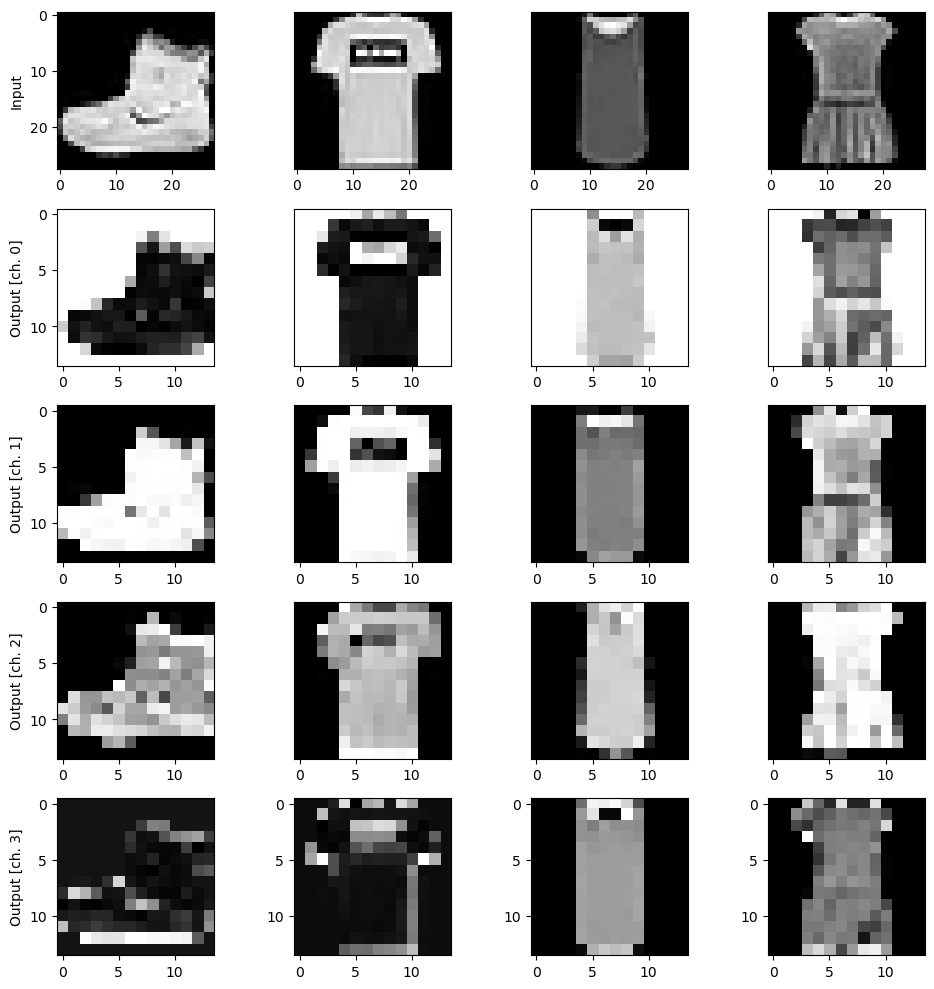

In [7]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [8]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [9]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=1,
)

Epoch 1/30


2024-08-09 18:01:08.235331: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 0s 4ms/step - loss: 2.5556 - accuracy: 0.1800 - val_loss: 1.6881 - val_accuracy: 0.3667
Epoch 2/30
25/25 [==============================] - 0s 1ms/step - loss: 1.2595 - accuracy: 0.6200 - val_loss: 1.2874 - val_accuracy: 0.5667
Epoch 3/30
25/25 [==============================] - 0s 1ms/step - loss: 0.8859 - accuracy: 0.7500 - val_loss: 1.1370 - val_accuracy: 0.6000
Epoch 4/30
25/25 [==============================] - 0s 993us/step - loss: 0.6903 - accuracy: 0.8100 - val_loss: 1.0529 - val_accuracy: 0.5667
Epoch 5/30
25/25 [==============================] - 0s 997us/step - loss: 0.5439 - accuracy: 0.8500 - val_loss: 0.9588 - val_accuracy: 0.7000
Epoch 6/30
25/25 [==============================] - 0s 995us/step - loss: 0.4487 - accuracy: 0.9200 - val_loss: 0.9574 - val_accuracy: 0.7333
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3855 - accuracy: 0.9400 - val_loss: 0.9625 - val_accuracy: 0.5667
Epoch 8/30
25/25 [=======

In [10]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
25/25 - 0s - loss: 2.1010 - accuracy: 0.2100 - val_loss: 1.7153 - val_accuracy: 0.3667 - 182ms/epoch - 7ms/step
Epoch 2/30
25/25 - 0s - loss: 1.3957 - accuracy: 0.5400 - val_loss: 1.3365 - val_accuracy: 0.6333 - 24ms/epoch - 952us/step
Epoch 3/30
25/25 - 0s - loss: 1.0965 - accuracy: 0.6700 - val_loss: 1.2169 - val_accuracy: 0.6333 - 24ms/epoch - 949us/step
Epoch 4/30
25/25 - 0s - loss: 0.9392 - accuracy: 0.7700 - val_loss: 1.1521 - val_accuracy: 0.6333 - 22ms/epoch - 896us/step
Epoch 5/30
25/25 - 0s - loss: 0.8098 - accuracy: 0.7800 - val_loss: 1.0498 - val_accuracy: 0.6333 - 23ms/epoch - 915us/step
Epoch 6/30
25/25 - 0s - loss: 0.7000 - accuracy: 0.8500 - val_loss: 1.0093 - val_accuracy: 0.6333 - 22ms/epoch - 899us/step
Epoch 7/30
25/25 - 0s - loss: 0.6345 - accuracy: 0.8500 - val_loss: 0.9883 - val_accuracy: 0.6333 - 22ms/epoch - 893us/step
Epoch 8/30
25/25 - 0s - loss: 0.5757 - accuracy: 0.8500 - val_loss: 0.9275 - val_accuracy: 0.6667 - 22ms/epoch - 894us/step
Epoch 9/3

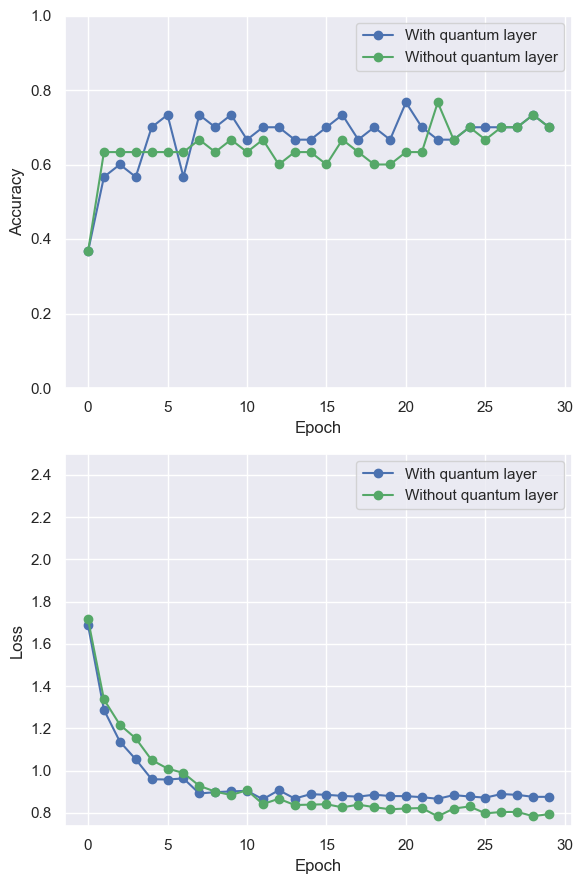

In [11]:
sns.set_theme()

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

As you can see, we didn't get an advantage for using a quantum kernel. This might be disappointing, but this model is just a starting point for an idea where we can incorporate quantum computing in machine learning models. Hopefully, in the future we will find use cases where quantum computing is essential to machine learning models.

Would adding more quantum layers help? I tried but more random quantum layers doesn't mean better results. Too much randomness kills the structure in our data. To get better results using quantum mechanics, my hope is in training the quantum kernel, which is computationally expensive to simulate. You can create a rough intuition about how expensive training a quantum kernel would be if you look at how long it took us to just run a random circuit. Creating a learning gradiant will take much more time.

### References
1) https://arxiv.org/pdf/1904.04767
2) https://arxiv.org/abs/1810.03787